In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
def sawtooth(x, *param):
    amplitude = param[0]
    shift     = param[1]
    offset    = param[2]
    period    = 360 

    return offset + (-2*amplitude/np.pi)*np.arctan(1/np.tan(((x-shift)*np.pi/period)))

def sawtooth_inv(x,*param):
    amplitude = param[0]
    shift     = param[1]
    offset    = param[2]
    period    = 360
    
    possible = shift+(period/np.pi)*np.arctan(1/np.tan((np.pi/(-2*amplitude))*(x-offset)))
    #possible = (period/np.pi)*np.arctan(1/np.tan((np.pi/(-2*amplitude))*(x-offset)))
    possible[possible<0]=possible[possible<0]+period

    return possible

def sawtooth_inv_corr(x,*param):
    amplitude = param[0]
    shift     = param[1]
    offset    = param[2]
    period    = 360
    
    #possible = shift+(period/np.pi)*np.arctan(1/np.tan((np.pi/(-2*amplitude))*(x-offset)))
    possible = (period/np.pi)*np.arctan(1/np.tan((np.pi/(-2*amplitude))*(x-offset)))
    possible[possible<0]=possible[possible<0]+period

    return possible

In [3]:
class fitting_nohist(object):
    def __call__(self, data, time, fit_func, guess, sigmas, bounds=[]):
        self.bins  = time
        self.data  = data
        self.fit_func = fit_func
        self.guess  = guess
        self.bounds = bounds
  
        try:
            self.coeff, self.var_matrix = curve_fit(self.fit_func, self.bins,
                                                    self.data, p0=self.guess,
                                                    ftol=1E-12, maxfev=100000,
                                                    #bounds=self.bounds,
                                                    method='lm'
                                                    )

            self.perr = np.sqrt(np.absolute(np.diag(self.var_matrix)))
            # Error in parameter estimation
        except:
             print("Fitting Problems")

        self.fit = self.fit_func(self.bins, *self.coeff)
        
        self.chisq = np.sum(((self.data-self.fit)/sigmas)**2)
        self.df = len(self.bins)-len(self.coeff)
        self.chisq_r = self.chisq/self.df
        #Gets fitted function and chisqr_r

    def evaluate(self,in_data):
        return self.fit_func(in_data,*self.coeff)

In [4]:
def TDC_fit(data, canal, tac, guess=[-82,0,280], plot=False):
    chisq_r = 100
    amplitude = guess[0]
    shift     = guess[1]
    offset    = guess[2]
    period    = 360
    
    while((chisq_r > 1) & (shift < 360)):
        datos = data[(data.tac==tac)&(data.channel==canal)]
        Q_fit = fitting_nohist()
        coeff  = [amplitude,period,shift,offset]
        
        Q_fit(datos.eval("mean"),datos.phase,sawtooth,[amplitude,shift,offset],datos.sigma)
        
        chisq_r = Q_fit.chisq_r
        print("Channel = %d / CHISQR_r = %f" % (canal,chisq_r))
        
        shift = shift + 10
    
    if plot==True:
        plt.figure()
        phase_fine = np.arange(0,360)
        plt.plot(phase_fine,Q_fit.evaluate(phase_fine),'b-',label="Fit")
        plt.errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                     fmt='.',color='red',label="Data")
        plt.xlabel("PHASE")
        plt.ylabel("TFINE")
        plt.legend()
        
    return chisq_r, Q_fit

In [5]:
filename = "/home/viherbos/DATA_daq/tfine_calibration.h5"
data = pd.read_hdf(filename)
print(np.mean(data[(data.tac==0) & (data.channel==0)].sigma))

1.9559709340517983


Channel = 60 / CHISQR_r = 1026.725809
Channel = 60 / CHISQR_r = 0.661036


/home/viherbos/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


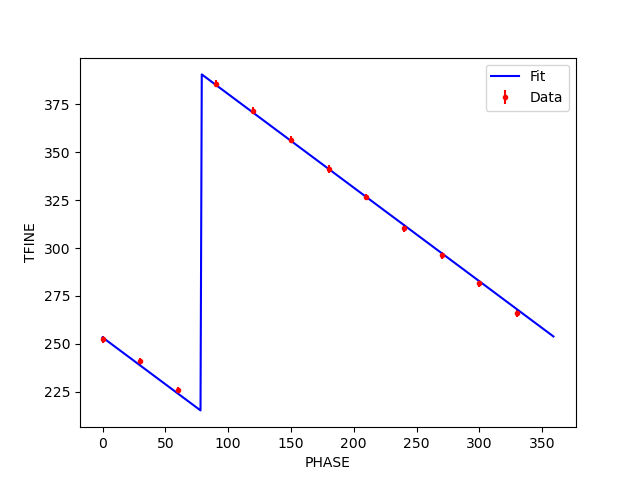

In [6]:
chi2,Q_fit = TDC_fit(data, 60, 0, plot=True)

In [7]:
Q_fit.coeff

array([-87.97323203,  78.21109508, 303.09536635])

<IPython.core.display.Javascript object>


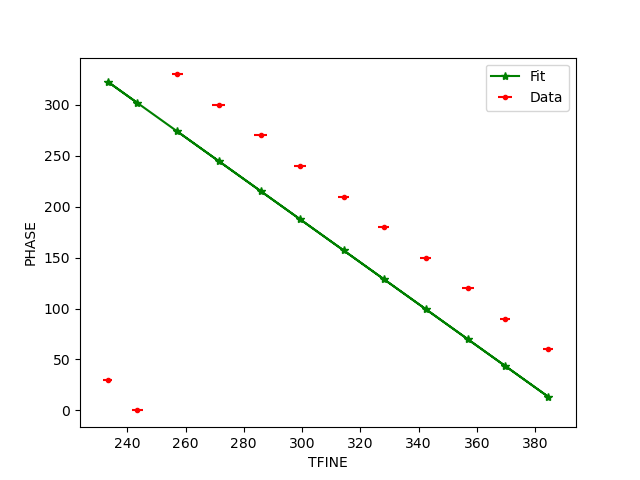

In [8]:
plt.figure()
canal = 43
tac=0
datos = data[(data.tac==tac)&(data.channel==canal)]

plt.errorbar(datos.eval("mean"),datos.phase, xerr=datos.sigma,
             fmt='.',color='red',label="Data")
plt.ylabel("PHASE")
plt.xlabel("TFINE")
inverse = sawtooth_inv_corr(datos.eval("mean"),*Q_fit.coeff)

plt.plot(datos.eval("mean"),inverse,'g-*',label="Fit")
plt.legend()

tac=0
A=[TDC_fit(data, i, tac=tac) for i in range(64)]

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(0,4):
    for j in range(0,4):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(4,8):
    for j in range(0,4):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(0,4):
    for j in range(4,8):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()

tac=0
fig, axs = plt.subplots(4, 4)
x=y=0
for i in range(4,8):
    for j in range(4,8):
        datos = data[(data.tac==tac)&(data.channel==i*8+j)]
        axs[y,x].plot(datos.phase,A[i*8+j][1].evaluate(datos.phase),'b-',label="Fit")
        axs[y,x].errorbar(datos.phase,datos.eval("mean"), datos.sigma,
                          fmt='.',color='red',label="Data")
        axs[y,x].set_xlabel("PHASE")
        axs[y,x].set_ylabel("TFINE")
        x=x+1
    y=y+1
    x=0
        
fig.tight_layout()
plt.legend()